# Lab 6b - Spectral Clustering

This notebook introduces Spectral Clustering,

It is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
*Spectral Clustering* is a partitioning method, but it is designed for different objectives than K-Means.

Spectral clustering is a totally different approach from K-Means and is aimed at discovering cluster shapes that are *not convex*. In machine learning, there are several famous such examples, such as the *spirals* data set (used in this notebook) and the Swiss roll data set. Spectral clustering approaches the problem by reprojecting the observations onto a new set of axes, based on eigenvalues and eigenvectors (hence, *spectral* clustering).

The empirical illustration uses the example in Chapter 8 of the Spatial Cluster book.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the same specification as in the previous notebooks:

In addition to the usual geopandas and matplotlib, we also import several specialized packages from scikit-learn. Specifically, to carry out variable standardization we again import `StandardScaler` from `sklearn.preprocessing`. The specific methods are `Kmeans` and `SpectralClustering` from `sklearn.cluster`. Finally, we import the helper functions `cluster_stats`, `cluster_fit` and `cluster_map` from `spatial_cluster_course`.

In [1]:
import geopandas as gpd

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

from spatial_cluster_course import cluster_stats, cluster_fit, cluster_map

### Load data

To illustrate spectral clustering, we use the *spirals* data set that is one of the `GeoDa` sample data sets. The easiest way to create it as a data folder for the notebooks is to use `Save As` in `GeoDa` and specify an ESRI shape file as the output. 

The data are also available from https://geodacenter.github.io/data-and-lab/Spirals/, but only as a csv text file. In order to turn this into a geodataframe, you must first read it into a pandas data frame using `read_csv`. In a second step, you create a point geodataframe by specifying `points_from_xy` and passing the coordinates (see the example in https://anitagraser.com/2019/01/23/from-csv-to-geodataframe-in-two-lines/). 

Note that the spirals data have no projection, they are just points in two-dimensional space. We use them as a geodataframe to facilitate visualization.

The following files will be used:
- **spirals.shp,shx,dbf**: shape file (three files) for 300 points

We follow the usual practice of setting a path (if needed), reading the data from the shape file and a quick check of its contents (`head`). We also generate a rudimentary plot of the points.

In [ ]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the spirals as point data:
dfs = gpd.read_file(path+"spirals/spirals.shp")
print(dfs.shape)
dfs.head(3)

(300, 4)


,x,y,cl,geometry
0,0.812357,-0.987127,1.0,POINT (0.81236 -0.98713)
1,-0.267589,-0.325520,1.0,POINT (-0.26759 -0.32552)
2,0.373975,-0.012937,2.0,POINT (0.37397 -0.01294)


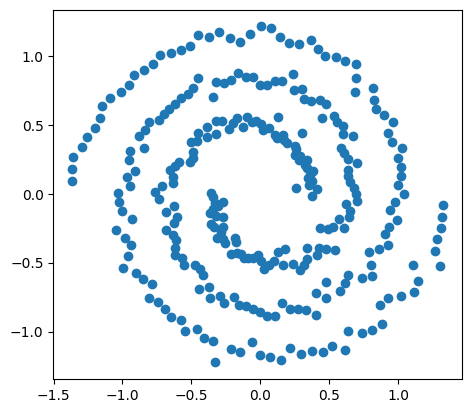

In [3]:
dfs.plot()
plt.show()

Finally, we set up the scaling factor for compatibility with `GeoDa` (`nn`), specify the number of clusters as 2, and create the scaled input array as `X`.

In [4]:
n = dfs.shape[0]
nn = (n - 1.0)/n

In [5]:
n_clusters = 2
data_cluster = dfs[['x','y']]
X0 = StandardScaler().fit_transform(data_cluster)
X = X0 * nn

## K-Means Clustering

We start by illustrating the results of a K-Means clustering on the spirals data. We call `KMeans` from `sklearn.cluster` and pass the number of clusters, `k-means++` as the initialization method and a `random_state`.

We summarize the results with our usual helper functions `cluster_stats`, `cluster_fit` and `cluster_map`.

   Labels  Cardinality
0       0          151
1       1          149

Total Sum of Squares (TSS): 597.9999999999999
Within-cluster Sum of Squares (WSS) for each cluster: [183.227 180.93 ]
Total Within-cluster Sum of Squares (WSS): 364.157
Between-cluster Sum of Squares (BSS): 233.843
Ratio of BSS to TSS: 0.391


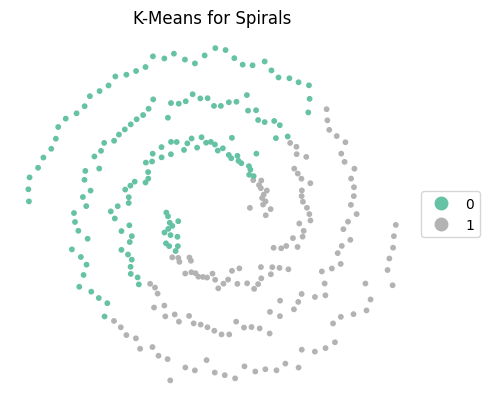

In [6]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=1234567).fit(X)
cluster_labels = kmeans.labels_
print(cluster_stats(cluster_labels))
clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels,
                      correct=True,n_clusters=n_clusters)
cluster_map(dfs,cluster_labels,title="K-Means for Spirals",cmap='Set2')

The results reveal a fairly balanced cluster, but it completely misses the separation between the two spirals. The BSS/TSS ratio is pretty dismal as well.

## Spectral Clustering

We now apply the spectral clustering method as `SpectralClustering` from `sklearn.cluster` (for details, see https://scikit-learn.org/1.6/modules/generated/sklearn.cluster.SpectralClustering.html). Besides the usual number of clusters (`n_clusters`) and `random_state`, this also takes several other arguments to fine tune the approach.

In our example, and to replicate the results in Chapter 8, we use `nearest_neighbors` to construct the affinity matrix (the argument `affinity`) and start by setting `n_neighbors=3`. 

In the usual manner, we apply the `fit` method to the cluster instance. The main result are the cluster labels, again contained in the `labels_` attribute. We apply our helper functions to summarize the results.

   Labels  Cardinality
0       0           96
1       1          204

Total Sum of Squares (TSS): 597.9999999999999
Within-cluster Sum of Squares (WSS) for each cluster: [195.746 340.538]
Total Within-cluster Sum of Squares (WSS): 536.284
Between-cluster Sum of Squares (BSS): 61.716
Ratio of BSS to TSS: 0.103


/opt/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


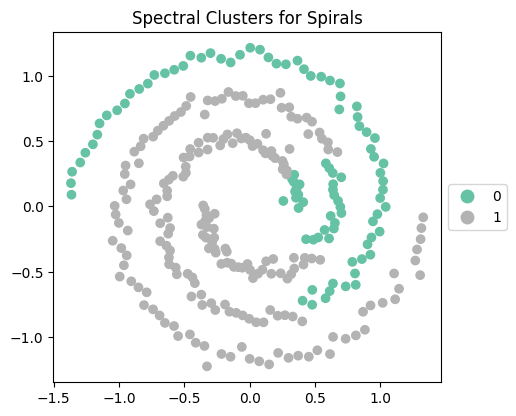

In [27]:
spectral = SpectralClustering(n_clusters=n_clusters, random_state=1234567, affinity='nearest_neighbors', n_neighbors=3).fit(X)
cluster_labels = spectral.labels_
print(cluster_stats(cluster_labels))
clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels,
                      correct=True,n_clusters=n_clusters)
cluster_map(dfs,cluster_labels,title="Spectral Clusters for Spirals",cmap='Set2')

The result is an unbalanced set of clusters that does better than K-Means at following the spirals, but is by no means satisfactory. The BSS/TSS ratio is also pretty dismal (0.103), but this is not surprising since it is the wrong criterion to assess a clustering of non-convex data.

We fine tune the approach by setting `n_neighbors=4` and summarize the result.

/opt/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   Labels  Cardinality
0       0          150
1       1          150

Total Sum of Squares (TSS): 597.9999999999999
Within-cluster Sum of Squares (WSS) for each cluster: [285.729 287.864]
Total Within-cluster Sum of Squares (WSS): 573.594
Between-cluster Sum of Squares (BSS): 24.406
Ratio of BSS to TSS: 0.041


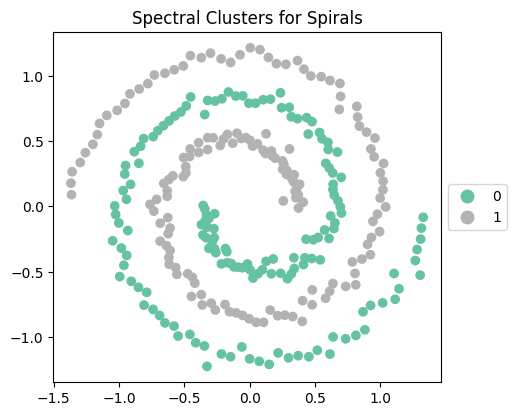

In [29]:
spectral = SpectralClustering(n_clusters=n_clusters, random_state=1234567, affinity='nearest_neighbors', n_neighbors=4).fit(X)
cluster_labels = spectral.labels_
print(cluster_stats(cluster_labels))
clusfit = cluster_fit(data=data_cluster,clustlabels=cluster_labels,
                      correct=True,n_clusters=n_clusters)
cluster_map(dfs,cluster_labels,title="Spectral Clusters for Spirals",cmap='Set2')

These settings yield a perfectly balanced set of clusters that is able to identify the two spirals exactly.

In practice, it may take some experimenting to find a satisfactory solution. Also, one typically does not know beforehand whether the data is highly non-convex of not. Nevertheless, spectral clustering has become one of the most commonly used methods.